# Neuroevolución
- ### La neuroevolución es una técnica de inteligencia artificial que combina redes neuronales con algoritmos evolutivos.
- ### Optimiza automáticamente la estructura y parámetros de una red.

## Inspiración biológica:

- ### Se basa en la evolución natural (selección, mutación y recombinación).

- ### Las redes neuronales "evolucionan" para adaptarse a una tarea.

## Tipos principales:

- ### Evolución de pesos: Optimiza los parámetros: pesos y sesgos ($bias$) de una red fija.

- ### Evolución de topologías: Modifica la arquitectura de la red (Por ejemplo, el método NEAT).

## Ventajas:

- ### No requiere del cálculo de gradientes (útil para problemas no diferenciables).

- ### Explora múltiples soluciones en paralelo.

- ### Puede descubrir arquitecturas novedosas.

## Aplicaciones:

- ### Control de robots.

- ### Juegos (Por ejemplo, videojuegos clásicos).

- ### Optimización de hiperparámetros.

## Algoritmos populares:

- ### NEAT (NeuroEvolution of Augmenting Topologies).

- ### CMA-ES (Covariance Matrix Adaptation Evolution Strategy).


## Clasificación de Textos por medio de Neuroevolución

<img src="figs/fig-diagrama-clasificador.png" width="900">

# Entrenar al clasificador

### Clasificador: Red Neuronal Multicapa
- #### Define una red con una arquitectura que consta de:
    - #### 2 datos de entrada ($x_1$, $x_2$)
    - #### capa 1 (4 neuronas)
    - #### capa 2 (3 neuronas)
    - #### capa 3 (2 neuronas): 2 datos de salida ($y_1$, $y_2$)

<center>
<img src="figs/fig-red_neuronal.png" width="800" style="background-color:white;">
</center>



- #### Número de parámetros de la red:
    - #### Pesos en la capa 1: $w_{ij}^{(1)}$ = 8 (2 entradas x 4 neuronas) y   4 sesgos ($bias$) (1 de cada neurona)
    - #### Pesos en la capa 2: $w_{ij}^{(2)}$ = 12 (4 entradas [4 neuronas de la capa 1] x 3 neuronas) y  3 sesgos ($bias$) (1 de cada neurona)
    - #### Pesos en la capa 3: $w_{ij}^{(3)}$ = 6 (3 entradas [3 neuronas de la capa 2] x 2 neuronas) y  2 sesgos ($bias$) (1 de cada neurona)
    - #### Total de parámetros: 35 (pesos y $bias$)



### 1. Cargar los datos

In [1]:
import pandas as pd
dataset = pd.read_json("./data/dataset_polaridad_es_train.json", lines=True)
#conteo de clases
print("Total de ejemplos de entrenamiento")
print(dataset.klass.value_counts())
# Extracción de los textos en arreglos de numpy
X = dataset['text'].to_numpy()
# Extracción de las etiquetas o clases de entrenamiento
Y = dataset['klass'].to_numpy()


Total de ejemplos de entrenamiento
klass
neutral     1485
positive     968
negative     689
Name: count, dtype: int64


### 2. Codificar las categorías (clases)

In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import torch
from torch import nn
# Normalizar las etiquetas a una codificación ordinal para entrada del clasificador
Y_encoded= le.fit_transform(Y)
print("Clases:")
print(le.classes_)
print("Clases codificadas:")
print(le.transform(le.classes_))


Clases:
['negative' 'neutral' 'positive']
Clases codificadas:
[0 1 2]


### 3. Preparar los conjuntos de datos  (datasets) para entrenamiento y para probar el rendimiento del clasificador

In [3]:
# Dividir el conjunto de datos en conjunto de entrenamiento (80%) y conjunto de pruebas (20%)
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val =  train_test_split(X, Y_encoded, test_size=0.2, stratify=Y_encoded, random_state=42)


### 4. Crear Matriz Documento-Término

In [4]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
import numpy as np

_STOPWORDS = stopwords.words("spanish")  # agregar más palabras a esta lista si es necesario

# Normalización del texto

import unicodedata
import re
PUNCTUACTION = ";:,.\\-\"'/"
SYMBOLS = "()[]¿?¡!{}~<>|"
NUMBERS= "0123456789"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)
SKIP_SYMBOLS_AND_SPACES = set(PUNCTUACTION + SYMBOLS + '\t\n\r ')

def normaliza_texto(input_str,
                    punct=False,
                    accents=False,
                    num=False,
                    max_dup=2):
    """
        punct=False (elimina la puntuación, True deja intacta la puntuación)
        accents=False (elimina los acentos, True deja intactos los acentos)
        num= False (elimina los números, True deja intactos los acentos)
        max_dup=2 (número máximo de símbolos duplicados de forma consecutiva, rrrrr => rr)
    """
    
    nfkd_f = unicodedata.normalize('NFKD', input_str)
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        if not num:
            if c in NUMBERS:
                continue
        if not punct:
            if c in SKIP_SYMBOLS:
                continue
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
    texto = unicodedata.normalize('NFKD', "".join(n_str))
    texto = re.sub(r'(\s)+', r' ', texto.strip(), flags=re.IGNORECASE)
    return texto


# Preprocesamiento personalizado 
def mi_preprocesamiento(texto):
    #convierte a minúsculas el texto antes de normalizar
    tokens = word_tokenize(texto.lower())
    texto = " ".join(tokens)
    texto = normaliza_texto(texto)
    return texto
    
# Tokenizador personalizado 
def mi_tokenizador(texto):
    # Elimina stopwords: palabras que no se consideran de contenido y que no agregan valor semántico al texto
    #print("antes: ", texto)
    texto = [t for t in texto.split() if t not in _STOPWORDS]
    #print("después:",texto)
    return texto

N_GRAMAS = 1
vec_tfidf = TfidfVectorizer(analyzer="word", preprocessor=mi_preprocesamiento, tokenizer=mi_tokenizador,  ngram_range=(1,N_GRAMAS))
X_train_tfidf = vec_tfidf.fit_transform(X_train)
X_train_tfidf = X_train_tfidf.toarray()

print("vocabulario: ", len(vec_tfidf.get_feature_names_out()))




X_val_tfidf = vec_tfidf.transform(X_val)
X_val_tfidf= X_val_tfidf.toarray()
Y_train = Y_train[:, np.newaxis] # Agregar una dimensión adicional para representar 1 ejemplo de entrenamiento por fila
Y_val = Y_val[:, np.newaxis] # Agregar una dimensión adicional para representar 1 ejemplo de entrenamiento por fila

print(Y_train)


vocabulario:  5660
[[0]
 [1]
 [0]
 ...
 [1]
 [2]
 [0]]


/Users/admin/opt/miniconda3/envs/CE/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### 5. Definición de la arquitectura de la red

In [5]:
from torch import nn
import numpy as np
# Definir la red neuronal en PyTorch heredando de la clase base de Redes Neuronales: Module
class RedNeuronal(nn.Module):
    def __init__(self, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion = 0.3):
        super().__init__()
        # Redondeado hacia arriba, reducir con la tasa de reducción "reduction_rate"
        self.tam_capa_oculta2 = int(tam_capa_oculta - np.ceil(tam_capa_oculta * tasa_reduccion))
        # print(f"tamaño capa oculta2: {self.tam_capa_oculta2 }")

        # Definición de capas, funciones de activación e inicialización de pesos
        # Capa Fully Connected (Capa Totalmente Conectada)
        self.fc1 = nn.Linear(tam_entrada, tam_capa_oculta)
        self.fc2 = nn.Linear(tam_capa_oculta, self.tam_capa_oculta2)
        self.fc3 = nn.Linear(self.tam_capa_oculta2, tam_salida)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.tam_capa_1_pesos = tam_entrada * tam_capa_oculta 
        self.tam_capa_1_bias  =  tam_capa_oculta # bias 
        self.tam_capa_2_pesos = tam_capa_oculta * self.tam_capa_oculta2 
        self.tam_capa_2_bias =  self.tam_capa_oculta2 # bias 
        self.tam_capa_3_pesos = self.tam_capa_oculta2 * tam_salida
        self.tam_capa_3_bias =  tam_salida # bias 
        self.tam_individuo = int(self.tam_capa_1_pesos + self.tam_capa_1_bias  +  self.tam_capa_2_pesos + self.tam_capa_2_bias + self.tam_capa_3_pesos + self.tam_capa_3_bias)
        # print(f"tamaño individuo (genoma): {self.tam_individuo  }")

    def forward(self, X):
        # Definición del orden de conexión de las capas y aplición de las funciones de activación
        out = self.fc1(X)
        out = self.relu(out)  # Aplicamos la función de activación
        out = self.fc2(out)
        out = self.relu(out)  # Aplicamos la función de activación
        out = self.fc3(out)
        out = self.softmax(out)  # Aplicamos la activación softmax para obtenr la probabilidad de cada neurona de salida
        return out

### 6. Definición del algoritmo evolutivo

In [6]:
import torch
import numpy as np
import random
from sklearn.metrics import f1_score


def inicializar_poblacion(tam_poblacion, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion):
    # Cada individuo es del tamaño del total de los pesos y bias que conforman a la red neuronal
    # Un individuo está formado por los pesos y bias de todas sus capas en forma de un vector
    # indviduo = [w11(1), w12(1), w13(1), b1(1), b2(1), w11(2), w12(2, b1(2), b2(2), ....]
    # w11(1) representa el peso w11 de la capa 1
    # wij(n) representa un peso i,j de la capa n
    # bk(n) representa un sesgo (bias) k de la capa n
    
    red = RedNeuronal(tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)    
    tam_individuo = red.tam_individuo
    poblacion = np.random.uniform(low=-0.5, high=0.5, size=(tam_poblacion, tam_individuo))
    return poblacion
    

def ajustar_estructura_red_neuronal(individuo, red_neuronal, tam_entrada, tam_capa_oculta, tam_salida):
 # Cargar pesos del individuo
    with torch.no_grad():
        # La matriz de pesos en Pytorch tienen la forma transpuesta (salida, entradas) a la inversa como se define la capa Lineal
        # Se reestablece el vector de pesos y bias que representa a cada individuo a su estrcutura de la red neuronal
        # 1. Se extraen las secciones (slice) del individuo (vector) que corresponden a la capa1 (fc1) y se extraen los bias de la capa1 (fc1)
        # 1.2. Se asignan a las secciones correspondiente de la red (weight.data) y (bias.data). 
        # 1.3.  Deben tener la misma forma (shape) que la estructura de la red definida, de lo contrario indicará el error.
        # 2. Se repiten el proceso para las capas restantes: desplazándose la sección de los pesos y bias de la primera capa (fc1) y extraer
        #    los pesos y bias de la capa2 (fc2) y asignarlos a los parámetros correspondientes.
        red_neuronal.fc1.weight.data = torch.from_numpy(individuo[:red_neuronal.tam_capa_1_pesos].reshape(tam_capa_oculta, tam_entrada)).float()
        desplazamiento_capa_1 =   red_neuronal.tam_capa_1_pesos + red_neuronal.tam_capa_1_bias
        red_neuronal.fc1.bias.data = torch.from_numpy(individuo[red_neuronal.tam_capa_1_pesos:desplazamiento_capa_1]).float()
        
        red_neuronal.fc2.weight.data = torch.from_numpy(individuo[desplazamiento_capa_1:desplazamiento_capa_1 + red_neuronal.tam_capa_2_pesos].reshape(red_neuronal.tam_capa_oculta2, tam_capa_oculta)).float()
        desplazamiento_capa_2 = desplazamiento_capa_1 + red_neuronal.tam_capa_2_pesos + red_neuronal.tam_capa_2_bias
        red_neuronal.fc2.bias.data = torch.from_numpy(individuo[desplazamiento_capa_1 + red_neuronal.tam_capa_2_pesos:desplazamiento_capa_2]).float()
        
        red_neuronal.fc3.weight.data = torch.from_numpy(individuo[desplazamiento_capa_2:desplazamiento_capa_2 + red_neuronal.tam_capa_3_pesos].reshape(tam_salida, red_neuronal.tam_capa_oculta2)).float()
        desplazamiento_capa_3 = desplazamiento_capa_2 + red_neuronal.tam_capa_3_pesos + red_neuronal.tam_capa_3_bias
        red_neuronal.fc3.bias.data = torch.from_numpy(individuo[desplazamiento_capa_2 + red_neuronal.tam_capa_3_pesos:desplazamiento_capa_3]).float()
    return red_neuronal

#  Función para evaluar el individuo (que representa su genoma)
def funcion_fitness(individuo, X, Y, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion):
    red_neuronal = RedNeuronal(tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)
    red_neuronal = ajustar_estructura_red_neuronal(individuo, red_neuronal, tam_entrada, tam_capa_oculta, tam_salida)

    # Calcular precisión

    X_tensor = torch.from_numpy(X).float()

    with torch.no_grad():

        y_pred = red_neuronal(X_tensor)
        # Obtiene una única clase, la más probable
        y_pred = torch.argmax(y_pred, dim=1)
        score = f1_score(Y, y_pred, average="macro")
            
    return score

def evaluar_fitness(poblacion,  X, Y, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion):
    fitness = []
    for individuo in poblacion:
        val_fitness = funcion_fitness(individuo, X, Y, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)
        fitness.append(val_fitness)
    return  np.array(fitness)

    
#------------------------------------------------------------------------
def seleccionar_padres(poblacion, aptitudes):
    """Selecciona dos padres mediante torneo."""
    torneo = random.sample(list(zip(poblacion, aptitudes)), k=4)
    torneo.sort(key=lambda x: x[1])  
    return torneo[0][0], torneo[1][0]

#------------------------------------------------------------------------
def elitismo(poblacion, fitness, tam_elite=2):
    """Selecciona los 'tam_elite' mejores best_individuos."""
    # Ordenar por fitness (mayor = mejor)
    ranked_indices = np.argsort(fitness)[::-1]
    elites = [poblacion[i] for i in ranked_indices[:tam_elite]]
    return elites


#------------------------------------------------------------------------
def cruzar(padre1, padre2):
    punto_cruza = np.random.randint(len(padre1))
    hijo1 = np.concatenate([padre1[:punto_cruza], padre2[punto_cruza:]])
    hijo2 = np.concatenate([padre2[:punto_cruza], padre1[punto_cruza:]])
    return hijo1, hijo2

#------------------------------------------------------------------------
def mutar(individuo, tasa_mutacion=0.1):
    # Crea la mascara de genes por mutar que cumplan con la condición
    mascara = np.random.rand(len(individuo)) < tasa_mutacion
    individuo = mascara * np.random.normal(0, 1, size=len(individuo))  # Mutar al individuo en los genes seleccionados 
    return individuo


    
def algoritmo_evolutivo(X, Y, tam_poblacion=30, num_generaciones=50):
    tam_entrada = X.shape[1] # Características TF-IDF, columnas
    tam_capa_oculta = 128
    tam_salida = 3  # 3 categorías
    tasa_reduccion = 0.3
        
    # Población inicial
    poblacion = inicializar_poblacion(tam_poblacion, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)
    best_fitness_hist = []
    mean_fitness_hist = []

    for generacion in range(num_generaciones):
        # Evaluar fitness (usando el conjunto de entrenamiento)
        val_fitness = evaluar_fitness(poblacion,  X, Y, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)
        
        # Registrar estadísticas
        print("obteniendo mejor fitness" )
        best_fitness = np.max(val_fitness)
        print("obteniendo media fitness " )
        mean_fitness = np.mean(val_fitness)
        best_fitness_hist.append(best_fitness)
        mean_fitness_hist.append(mean_fitness)
        
        print(f"Generación {generacion + 1}: Mejor fitness = {best_fitness:.4f}, Fitness promedio = {mean_fitness:.4f}")
        nueva_poblacion = []

        for _ in range(tam_poblacion // 2):
            # Seleccionar padres
            padre1, padre2 = seleccionar_padres(poblacion, val_fitness)            
            # Crear descendencia mediante cruce
            hijo1, hijo2 = cruzar(padre1, padre2)
            hijo1 = mutar(hijo1)
            hijo2 = mutar(hijo2)
            nueva_poblacion.append(hijo1)            
            nueva_poblacion.append(hijo2)        
        
        
        #-----------------
        # Población: Los hijos sustituyen a los padres
        #-----------------
        # poblacion = np.array(nueva_poblacion)
    
        #-----------------
        # Población con elitismo de padres y parte de los hijos
        #-----------------
        nueva_poblacion = np.array(nueva_poblacion)
        K_best_padres = 5
        poblacion[:K_best_padres, ] = elitismo(poblacion, val_fitness, K_best_padres)
        poblacion[K_best_padres:, ] = nueva_poblacion[K_best_padres:, ]


    val_fitness = evaluar_fitness(poblacion,  X, Y, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)

    # Evaluar el mejor modelo en train
    best_individuo = poblacion[np.argmax(val_fitness)]
    test_f1 = funcion_fitness(best_individuo, X, Y, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)
    print(f"\nF1-score final en test: {test_f1:.3f}")
    return best_individuo


def predecir_clase(individuo, X, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion):
    red_neuronal = RedNeuronal(tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)
    red_neuronal = ajustar_estructura_red_neuronal(individuo, red_neuronal, tam_entrada, tam_capa_oculta, tam_salida)
 
    # Calcular precisión
    X_tensor = torch.from_numpy(X).float()

    with torch.no_grad():
        # Calcula las predicciones con la red neuronal con los pesos y bias definidos por el individuo
        y_pred = red_neuronal(X_tensor)
        y_pred = torch.argmax(y_pred, dim=1)
        return y_pred

### 7. Ejecución del algoritmo evolutivo

In [7]:

best_individuo = algoritmo_evolutivo(X_train_tfidf, Y_train, tam_poblacion=50, num_generaciones=50)

obteniendo mejor fitness
obteniendo media fitness 
Generación 1: Mejor fitness = 0.3254, Fitness promedio = 0.2456
obteniendo mejor fitness
obteniendo media fitness 
Generación 2: Mejor fitness = 0.3607, Fitness promedio = 0.2578
obteniendo mejor fitness
obteniendo media fitness 
Generación 3: Mejor fitness = 0.3607, Fitness promedio = 0.2611
obteniendo mejor fitness
obteniendo media fitness 
Generación 4: Mejor fitness = 0.3607, Fitness promedio = 0.2504
obteniendo mejor fitness
obteniendo media fitness 
Generación 5: Mejor fitness = 0.3607, Fitness promedio = 0.2588
obteniendo mejor fitness
obteniendo media fitness 
Generación 6: Mejor fitness = 0.3607, Fitness promedio = 0.2586
obteniendo mejor fitness
obteniendo media fitness 
Generación 7: Mejor fitness = 0.3607, Fitness promedio = 0.2547
obteniendo mejor fitness
obteniendo media fitness 
Generación 8: Mejor fitness = 0.3646, Fitness promedio = 0.2740
obteniendo mejor fitness
obteniendo media fitness 
Generación 9: Mejor fitness =

### 8. Prueba del mejor individuo en el conjunto de test

In [8]:
import numpy as np
import pandas as pd

tam_entrada = len(vec_tfidf.get_feature_names_out()) # Características TF-IDF
tam_capa_oculta = 128
tam_salida = 3  # 3 categorías
tasa_reduccion = 0.3

dataset_test = pd.read_json("./data/dataset_polaridad_es_test.json", lines=True)
#conteo de clases
print("Total de ejemplos de entrenamiento")
print(dataset_test.klass.value_counts())
# Extracción de los textos en arreglos de numpy
X_test = dataset_test['text'].to_numpy()
# Extracción de las etiquetas o clases de entrenamiento
Y_test = dataset_test['klass'].to_numpy()

X_test_tfidf = vec_tfidf.transform(X_test)
X_test_tfidf = X_test_tfidf.toarray()
Y_test = le.transform(Y_test)
Y_t = Y_test[:, np.newaxis] # Agregar una dimensión adicional para representar 1 ejemplo de entrenamiento por fila
y_pred_test = predecir_clase(best_individuo, X_test_tfidf, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)
print(Y_t[:5])
print(y_pred_test[:5])
score = f1_score(Y_t, y_pred_test, average="macro")
print(f"\nF1-score final en test: {score:.3f}")



Total de ejemplos de entrenamiento
klass
neutral     371
positive    242
negative    173
Name: count, dtype: int64
[[2]
 [1]
 [0]
 [1]
 [1]]
tensor([1, 2, 2, 2, 1])

F1-score final en test: 0.390


### Predicción de datos nuevos

In [18]:


tam_entrada = len(vec_tfidf.get_feature_names_out()) # Características TF-IDF
tam_capa_oculta = 128
tam_salida = 3  # 3 categorías
tasa_reduccion = 0.3


ejemplos_nuevos = ["Que triste no tener celular"]
# Suponer que se cuenta con el objeto vec_tfidf entrenado con el vocabulario del conjunto de entrenamiento
X_ejemplos_tfidf = vec_tfidf.transform(ejemplos_nuevos)
X_ejemplos_tfidf = X_ejemplos_tfidf.toarray()
y_pred_nuevo = predecir_clase(best_individuo, X_ejemplos_tfidf, tam_entrada, tam_capa_oculta, tam_salida, tasa_reduccion)
print(y_pred_nuevo)
y_pred_nuevo = y_pred_nuevo.flatten()
print(le.inverse_transform(y_pred_nuevo))


tensor([1])
['neutral']


# 9. Evaluando el desempeño

## Métricas de Evaluación
 - #### Las métricas precisión, recall y F1 son fundamentales para evaluar el rendimiento de un clasificador


<img src="figs/fig_precision-recall.png" width="300">

##### Fuente: https://en.wikipedia.org/wiki/Precision_and_recall


<img src="figs/fig_matriz-confusion.png" width="500">


TP=True Positive

TN=True Negative

FP=False Positive (Error tipo I: ejemplo, se considera que el paciente está enfermo, pero en realidad está sano)

FN=False Negative ( Error tipo II: ejemplo, se considera que el paciente está sano, pero en realidad está enfermo)


$$ Accuracy = \frac{total~ TP + total~TN}{total~muestras} $$

$$ Precision_c = \frac{ TP_c}{TP_c + FP_c} $$

$$ Recall_c = \frac{ TP_c}{TP_c + FN_c} $$

$$ F1-score_c= 2 \times \frac{ Precision_c \times Recall_c}{Precision_c + Recall_c} $$

$$ macro-F1-score= \frac{ 1 }{|Clases|} \sum{F1-score_c} $$

## Matriz de confusión

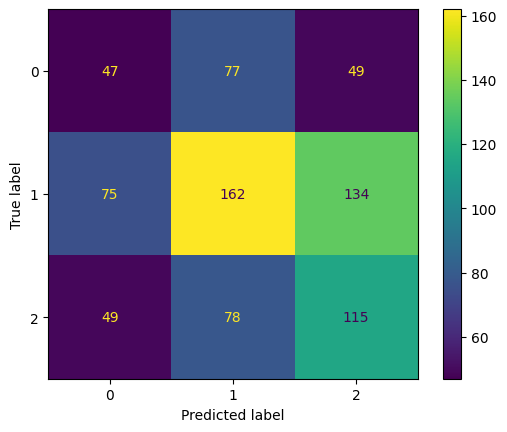

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_test)

## Métricas

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print("P=", precision_score(Y_test, y_pred_test, average='macro'))
print("R=", recall_score(Y_test, y_pred_test, average='macro'))
print("F1=", f1_score(Y_test, y_pred_test, average='macro'))
print("Acc=", accuracy_score(Y_test, y_pred_test))


P= 0.39060028363392313
R= 0.39451353136299444
F1= 0.3900373241458513
Acc= 0.4122137404580153


In [22]:
# Métricas de la clase 0, la precisión es la siguiente
tp= 47
fp = 75+49
tp/(tp + fp)

0.27485380116959063

## Inspección del desempeño por clase

In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, y_pred_test))

[[ 47  77  49]
 [ 75 162 134]
 [ 49  78 115]]


In [24]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred_test, digits=4, zero_division='warn'))

              precision    recall  f1-score   support

           0     0.2749    0.2717    0.2733       173
           1     0.5110    0.4367    0.4709       371
           2     0.3859    0.4752    0.4259       242

    accuracy                         0.4122       786
   macro avg     0.3906    0.3945    0.3900       786
weighted avg     0.4205    0.4122    0.4136       786



# Ejercicio 1

### 1. Probar diferentes tipos de preprocesamiento para ver el impacto en el rendimiento de los invidividuos evolucionandos:
- ### Preprocesamiento con Unigramas, bigramas, trigramas
- ### Stemming vs sin Stemming
- ### Porcentaje de features máximas (20, 30, 40)%
### 2. Probar diferentes tipos de operadores de variación:
- ### Cruza (1 punto, 2 puntos, n puntos)
### 3. Variar el tamaño de la población (considerar que en estos casos el costo computacional es mayor)
### 4. Variar el número de generaciones (considerar que en estos casos el costo computacional es mayor)
